c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
Majority Voting Ensemble Performance:
 Selected Features : ['Mean (µV)', 'RMS (µV)', 'MRS (µV)', 'Zero Crossings', 'Frequency (Hz)', 'Delta (µV² /Hz)', 'Theta (µV² /Hz)', 'Alpha (µV² /Hz)', 'Beta (µV² /Hz)', 'Gamma (µV² /Hz)', 'Skewness', 'Variance', 'Kurtosis', 'Hjorth Mobility', 'Hjorth Complexity', 'Spectral Entropy']
 Accuracy    : 0.7214
 Precision   : 0.7039
 Recall      : 0.7643
 F1 Score    : 0.7329
 Specificity : 0.6786


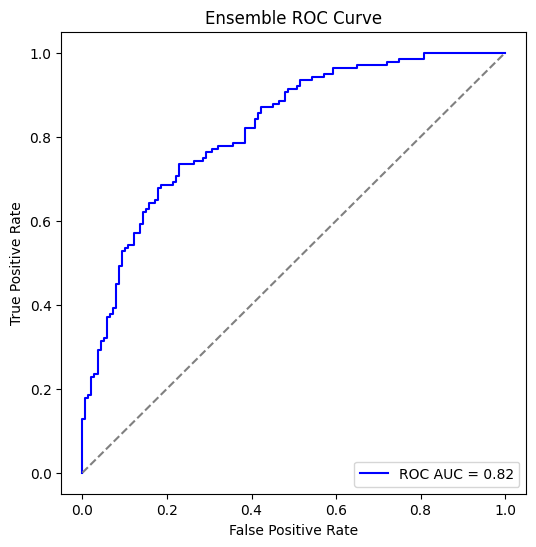

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Main script
# ---------------------------
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

# Reshape for RNN input: (samples, timesteps=1, features)
X_selected = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train RNN
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[2]))
model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

# Train LSTM
model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[2]))
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

# Train GRU
model_gru = build_gru_model(input_shape=(1, X_selected.shape[2]))
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Majority Voting Ensemble
all_preds = np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru]).T
ensemble_pred = (np.sum(all_preds, axis=1) >= 2).astype(int)

# Metrics
acc = accuracy_score(y_test, ensemble_pred)
prec = precision_score(y_test, ensemble_pred)
rec = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
spec = tn / (tn + fp)

print("Majority Voting Ensemble Performance:")
print(f" Selected Features : {selected_features.tolist()}")
print(f" Accuracy    : {acc:.4f}")
print(f" Precision   : {prec:.4f}")
print(f" Recall      : {rec:.4f}")
print(f" F1 Score    : {f1:.4f}")
print(f" Specificity : {spec:.4f}")

# ROC Curve with averaged probs for visualization only
ensemble_probs = (probs_rnn + probs_lstm + probs_gru) / 3
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# Feature selection
def select_features(X, y, k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# Build models
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Main
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, k=20)

# Reshape for RNN input (samples, timesteps=1, features)
X_selected = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train RNN
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[2]))
model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

# Train LSTM
model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[2]))
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

# Train GRU
model_gru = build_gru_model(input_shape=(1, X_selected.shape[2]))
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Majority Voting Ensemble
all_preds = np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru]).T
ensemble_pred = (np.sum(all_preds, axis=1) >= 2).astype(int)

# Print majority voting predictions per sample
print("Majority Voting Predictions for each test sample:")
for i, votes in enumerate(all_preds):
    majority = 1 if np.sum(votes) >= 2 else 0
    print(f"Sample {i}: Model votes = {votes}, Majority vote = {majority}")


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Majority Voting Predictions for each test sample:
Sample 0: Model votes = [1 1 1], Majority vote = 1
Sample 1: Model votes = [1 1 1], Majority vote = 1
Sample 2: Model votes = [0 0 0], Majority vote = 0
Sample 3: Model votes = [1 1 1], Majority vote = 1
Sample 4: Model votes = [0 0 0], Majority vote = 0
Sample 5: Model votes = [0 0 0], Majority vote = 0
Sample 6: Model votes = [1 1 1], Majority vote = 1
Sample 7: Model votes = [0 1 1], Majority vote = 1
Sample 8: Model votes = [1 1 1], Majority vote = 1
Sample 9: Model votes = [1 1 1], Majority vote = 1
Sample 10: Model votes = [1 1 1], Majority vote = 1
Sample 11: Model votes = [0 0 0], Majority vote = 0
Sample 12: Model votes = [0 1 1], Majority vote = 1
Sample 13: Model votes = [0 0 0], Majority vote = 0
Sample 14: Model votes = [0 0 0], Majority vote = 0
Sample 15: Model votes = [0 1 1], Majority vote = 1
Sample 16: Mod

c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Majority Voting Ensemble Performance:
 Selected Features : ['Mean (µV)', 'RMS (µV)', 'MRS (µV)', 'Zero Crossings', 'Frequency (Hz)', 'Delta (µV² /Hz)', 'Theta (µV² /Hz)', 'Alpha (µV² /Hz)', 'Beta (µV² /Hz)', 'Gamma (µV² /Hz)', 'Skewness', 'Variance', 'Kurtosis', 'Hjorth Mobility', 'Hjorth Complexity', 'Spectral Entropy']
 Accuracy    : 0.7250
 Precision   : 0.7143
 Recall      : 0.7500
 F1 Score    : 0.7317
 Specificity : 0.7000

Majority Voting Predictions and Models Voting for Majority per sample:
Sample 0: Majority Vote = 1, Voted by models: ['RNN', 'LSTM', 'GRU']
Sample 1: Majority Vote = 1, Voted by models: ['RNN', 'LSTM', 'GRU']
Sample 2: Majority Vote = 0, Voted by models: ['RNN', 'LSTM', 'GRU']
Sample 3: Majority Vote = 1, Voted by models: ['RNN', 'LSTM', 'GRU']
Sample 4: Majority Vote = 0, Voted by models: ['RNN', 'LSTM', 'GRU']
Sample 5: Majority Vote = 0, Voted b

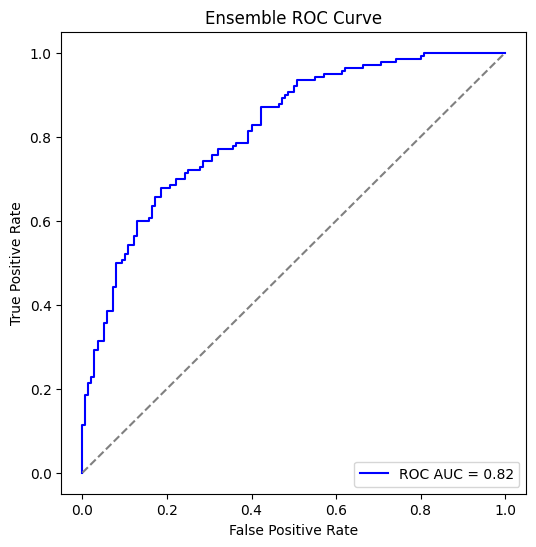

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Main script
# ---------------------------
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

# Reshape for RNN input: (samples, timesteps=1, features)
X_selected = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train RNN
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[2]))
model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

# Train LSTM
model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[2]))
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

# Train GRU
model_gru = build_gru_model(input_shape=(1, X_selected.shape[2]))
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Majority Voting Ensemble
all_preds = np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru]).T
ensemble_pred = (np.sum(all_preds, axis=1) >= 2).astype(int)

# Metrics
acc = accuracy_score(y_test, ensemble_pred)
prec = precision_score(y_test, ensemble_pred)
rec = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
spec = tn / (tn + fp)

print("Majority Voting Ensemble Performance:")
print(f" Selected Features : {selected_features.tolist()}")
print(f" Accuracy    : {acc:.4f}")
print(f" Precision   : {prec:.4f}")
print(f" Recall      : {rec:.4f}")
print(f" F1 Score    : {f1:.4f}")
print(f" Specificity : {spec:.4f}")

# Print which models voted for majority for each test sample
model_names = ['RNN', 'LSTM', 'GRU']
print("\nMajority Voting Predictions and Models Voting for Majority per sample:")

for i, votes in enumerate(all_preds):
    majority_vote = 1 if np.sum(votes) >= 2 else 0
    voters = [model_names[j] for j, v in enumerate(votes) if v == majority_vote]
    print(f"Sample {i}: Majority Vote = {majority_vote}, Voted by models: {voters}")

# ROC Curve with averaged probabilities for visualization only
ensemble_probs = (probs_rnn + probs_lstm + probs_gru) / 3
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve")
plt.legend(loc="lower right")
plt.show()


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Ensemble of 8 Models Performance:
 Selected Features : ['Mean (µV)', 'RMS (µV)', 'MRS (µV)', 'Zero Crossings', 'Frequency (Hz)', 'Delta (µV² /Hz)', 'Theta (µV² /Hz)', 'Alpha (µV² /Hz)', 'Beta (µV² /Hz)', 'Gamma (µV² /Hz)', 'Skewness', 'Variance', 'Kurtosis', 'Hjorth Mobility', 'Hjorth Complexity', 'Spectral Entropy']
 Accuracy    : 0.7500
 Precision   : 0.7215
 Recall      : 0.8143
 F1 Score    : 0.7651
 Specificity : 0.6857


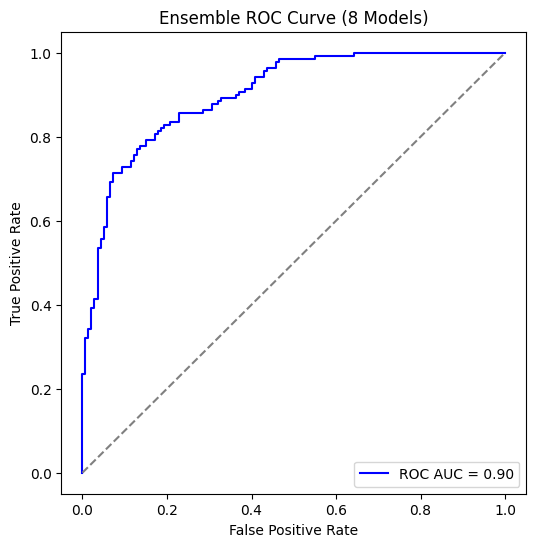

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Deep Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Main Script
# ---------------------------
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, k=20)

# For traditional models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train_skl, X_test_skl, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# For deep models
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_rnn, X_test_rnn = X_rnn[y_train.index], X_rnn[y_test.index]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train RNN
model_rnn = build_rnn_model(input_shape=(1, X_train_rnn.shape[2]))
model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test_rnn).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

# Train LSTM
model_lstm = build_lstm_model(input_shape=(1, X_train_rnn.shape[2]))
model_lstm.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test_rnn).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

# Train GRU
model_gru = build_gru_model(input_shape=(1, X_train_rnn.shape[2]))
model_gru.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test_rnn).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Traditional ML Models
models = {
    "svm": SVC(probability=True, random_state=42),
    "lr": LogisticRegression(max_iter=1000, random_state=42),
    "knn": KNeighborsClassifier(),
    "rf": RandomForestClassifier(random_state=42),
    "dt": DecisionTreeClassifier(random_state=42)
}

traditional_preds = []
probs_all = [probs_rnn, probs_lstm, probs_gru]

for name, clf in models.items():
    clf.fit(X_train_skl, y_train)
    probs = clf.predict_proba(X_test_skl)[:, 1]
    preds = (probs > 0.5).astype(int)
    traditional_preds.append(preds)
    probs_all.append(probs)

# Majority Voting Ensemble
all_preds = np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru] + traditional_preds).T
ensemble_pred = (np.sum(all_preds, axis=1) >= 4).astype(int)

# Metrics
acc = accuracy_score(y_test, ensemble_pred)
prec = precision_score(y_test, ensemble_pred)
rec = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
spec = tn / (tn + fp)

print("Ensemble of 8 Models Performance:")
print(f" Selected Features : {selected_features.tolist()}")
print(f" Accuracy    : {acc:.4f}")
print(f" Precision   : {prec:.4f}")
print(f" Recall      : {rec:.4f}")
print(f" F1 Score    : {f1:.4f}")
print(f" Specificity : {spec:.4f}")

# ROC Curve using average probabilities
ensemble_probs = np.mean(np.vstack(probs_all), axis=0)
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve (8 Models)")
plt.legend(loc="lower right")
plt.show()


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Deep Models (RNN+LSTM+GRU) Ensemble Performance:
 Accuracy    : 0.7071
 Precision   : 0.6883
 Recall      : 0.7571
 F1 Score    : 0.7211
 Specificity : 0.6571


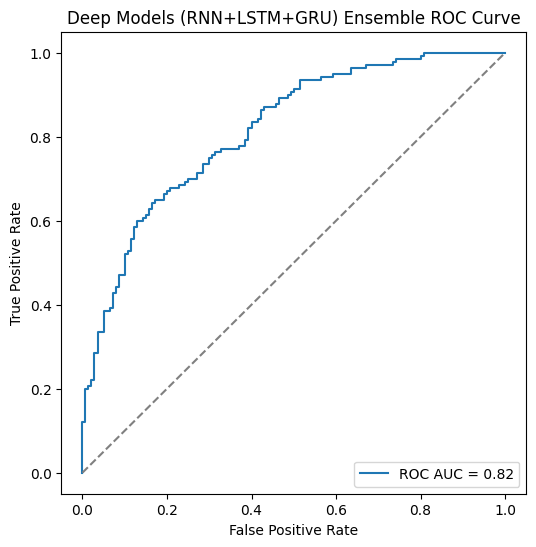


Traditional ML (LR+KNN+DT) Ensemble Performance:
 Accuracy    : 0.7821
 Precision   : 0.7516
 Recall      : 0.8429
 F1 Score    : 0.7946
 Specificity : 0.7214


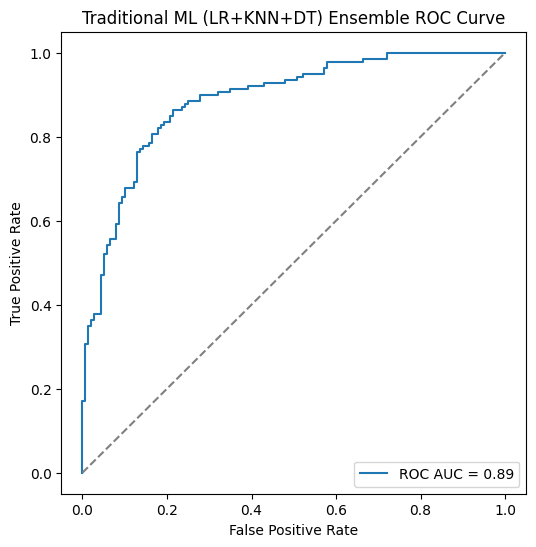


Mixed (RF+SVM+LSTM) Ensemble Performance:
 Accuracy    : 0.7607
 Precision   : 0.7325
 Recall      : 0.8214
 F1 Score    : 0.7744
 Specificity : 0.7000


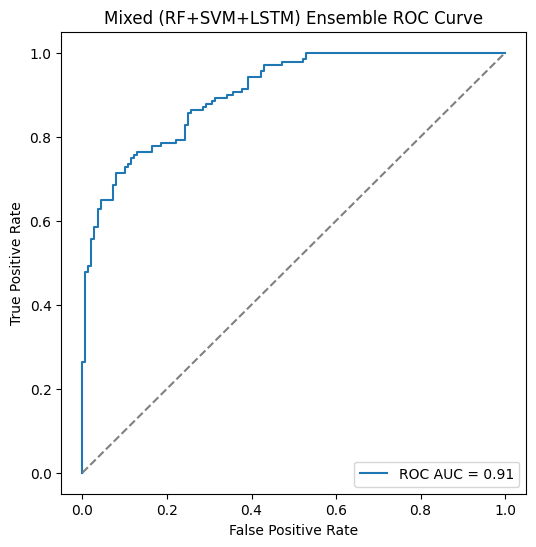

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Deep Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Train traditional ML models
# ---------------------------
def train_ml_models(X_train, y_train, X_test):
    models = {
        "logistic_regression": LogisticRegression(random_state=42, max_iter=1000),
        "knn": KNeighborsClassifier(n_neighbors=5),
        "decision_tree": DecisionTreeClassifier(random_state=42),
        "random_forest": RandomForestClassifier(random_state=42),
        "svm": SVC(probability=True, random_state=42)
    }
    trained_models = {}
    y_preds = {}
    y_probs = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        trained_models[name] = model
        y_preds[name] = y_pred
        y_probs[name] = y_prob

    return trained_models, y_preds, y_probs

# ---------------------------
# Main script
# ---------------------------
if __name__ == "__main__":
    X, y = load_dataset()
    X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

    # Reshape for RNN input: (samples, timesteps=1, features)
    X_reshaped = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

    # Split data for deep models and ML models
    X_train_deep, X_test_deep, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, stratify=y, random_state=42)
    X_train_ml, X_test_ml, _, _ = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train Deep Models
    model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[1]))
    model_rnn.fit(X_train_deep, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_rnn = model_rnn.predict(X_test_deep).ravel()
    y_pred_rnn = (probs_rnn > 0.5).astype(int)

    model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[1]))
    model_lstm.fit(X_train_deep, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_lstm = model_lstm.predict(X_test_deep).ravel()
    y_pred_lstm = (probs_lstm > 0.5).astype(int)

    model_gru = build_gru_model(input_shape=(1, X_selected.shape[1]))
    model_gru.fit(X_train_deep, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_gru = model_gru.predict(X_test_deep).ravel()
    y_pred_gru = (probs_gru > 0.5).astype(int)

    # Train traditional ML models
    ml_models, ml_preds, ml_probs = train_ml_models(X_train_ml, y_train, X_test_ml)

    # ---- Ensembling ----
    def print_ensemble_metrics(y_true, y_pred, y_prob, name):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        spec = tn / (tn + fp)

        print(f"\n{name} Ensemble Performance:")
        print(f" Accuracy    : {acc:.4f}")
        print(f" Precision   : {prec:.4f}")
        print(f" Recall      : {rec:.4f}")
        print(f" F1 Score    : {f1:.4f}")
        print(f" Specificity : {spec:.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} Ensemble ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    # Ensemble 1: Deep models (RNN, LSTM, GRU)
    preds_deep = np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru]).T
    ensemble_pred_deep = (np.sum(preds_deep, axis=1) >= 2).astype(int)
    probs_deep_avg = (probs_rnn + probs_lstm + probs_gru) / 3
    print_ensemble_metrics(y_test, ensemble_pred_deep, probs_deep_avg, "Deep Models (RNN+LSTM+GRU)")

    # Ensemble 2: Traditional ML (Logistic Regression, KNN, Decision Tree)
    preds_ml_1 = np.vstack([ml_preds["logistic_regression"], ml_preds["knn"], ml_preds["decision_tree"]]).T
    probs_ml_1 = (ml_probs["logistic_regression"] + ml_probs["knn"] + ml_probs["decision_tree"]) / 3
    ensemble_pred_ml_1 = (np.sum(preds_ml_1, axis=1) >= 2).astype(int)
    print_ensemble_metrics(y_test, ensemble_pred_ml_1, probs_ml_1, "Traditional ML (LR+KNN+DT)")

    # Ensemble 3: Mixed (Random Forest, SVM, LSTM)
    preds_mixed = np.vstack([ml_preds["random_forest"], ml_preds["svm"], y_pred_lstm]).T
    probs_mixed = (ml_probs["random_forest"] + ml_probs["svm"] + probs_lstm) / 3
    ensemble_pred_mixed = (np.sum(preds_mixed, axis=1) >= 2).astype(int)
    print_ensemble_metrics(y_test, ensemble_pred_mixed, probs_mixed, "Mixed (RF+SVM+LSTM)")



Ensemble Combo 1 (LSTM, GRU, RF, SVM, LR) Performance:
 Accuracy    : 0.7321
 Precision   : 0.7124
 Recall      : 0.7786
 F1 Score    : 0.7440
 Specificity : 0.6857


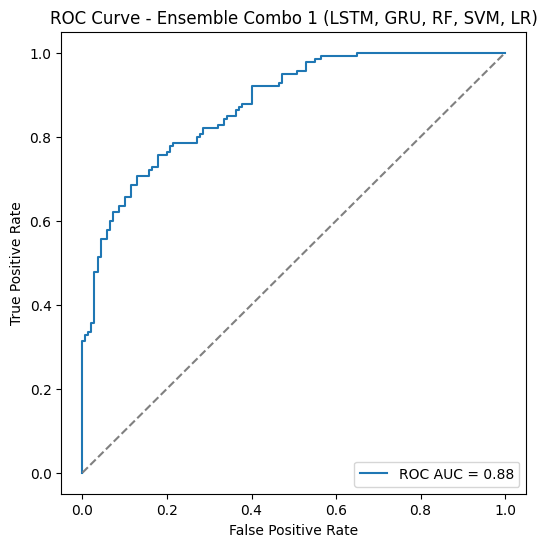


Ensemble Combo 2 (RNN, LSTM, KNN, DT, LR) Performance:
 Accuracy    : 0.7357
 Precision   : 0.7200
 Recall      : 0.7714
 F1 Score    : 0.7448
 Specificity : 0.7000


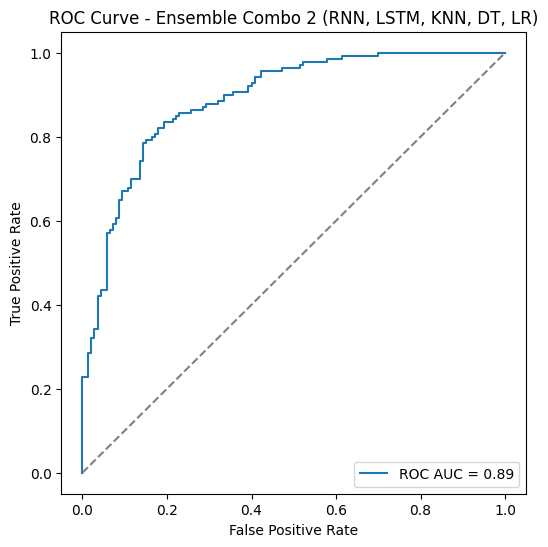


Ensemble Combo 3 (GRU, RNN, RF, KNN, DT) Performance:
 Accuracy    : 0.8143
 Precision   : 0.7857
 Recall      : 0.8643
 F1 Score    : 0.8231
 Specificity : 0.7643


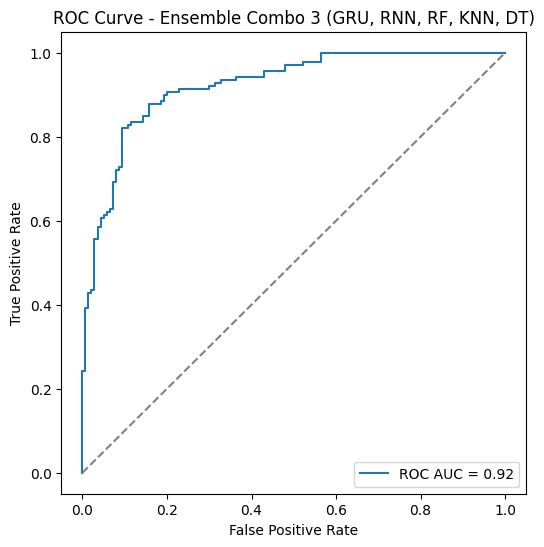


Ensemble Combo 4 (LSTM, GRU, RNN, SVM, DT) Performance:
 Accuracy    : 0.7214
 Precision   : 0.6962
 Recall      : 0.7857
 F1 Score    : 0.7383
 Specificity : 0.6571


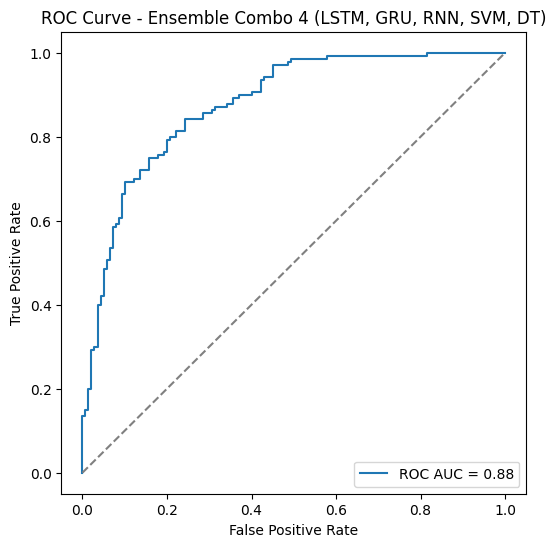


Ensemble Combo 5 (LSTM, RF, KNN, SVM, LR) Performance:
 Accuracy    : 0.7571
 Precision   : 0.7338
 Recall      : 0.8071
 F1 Score    : 0.7687
 Specificity : 0.7071


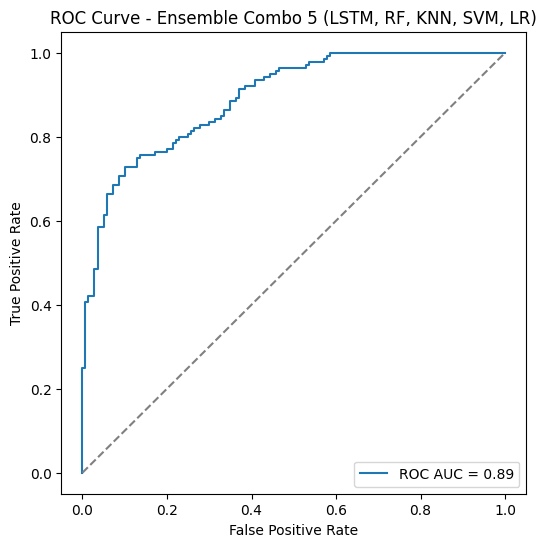

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Assume predictions and probabilities are available as below:
# Deep learning models
# y_pred_rnn, probs_rnn
# y_pred_lstm, probs_lstm
# y_pred_gru, probs_gru

# Classical ML models predictions and probabilities in dicts:
# ml_preds = {
#     "random_forest": y_pred_rf,
#     "svm": y_pred_svm,
#     "logistic_regression": y_pred_lr,
#     "knn": y_pred_knn,
#     "decision_tree": y_pred_dt,
# }

# ml_probs = {
#     "random_forest": probs_rf,
#     "svm": probs_svm,
#     "logistic_regression": probs_lr,
#     "knn": probs_knn,
#     "decision_tree": probs_dt,
# }

def print_ensemble_metrics(y_true, y_pred, y_probs, title):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp)

    print(f"\n{title} Performance:")
    print(f" Accuracy    : {acc:.4f}")
    print(f" Precision   : {prec:.4f}")
    print(f" Recall      : {rec:.4f}")
    print(f" F1 Score    : {f1:.4f}")
    print(f" Specificity : {spec:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()

# --- Ensemble Combination 1 ---
preds_combo1 = np.vstack([
    y_pred_lstm,
    y_pred_gru,
    ml_preds["random_forest"],
    ml_preds["svm"],
    ml_preds["logistic_regression"]
]).T

probs_combo1 = (
    probs_lstm +
    probs_gru +
    ml_probs["random_forest"] +
    ml_probs["svm"] +
    ml_probs["logistic_regression"]
) / 5

ensemble_pred_combo1 = (np.sum(preds_combo1, axis=1) >= 3).astype(int)
print_ensemble_metrics(y_test, ensemble_pred_combo1, probs_combo1, "Ensemble Combo 1 (LSTM, GRU, RF, SVM, LR)")

# --- Ensemble Combination 2 ---
preds_combo2 = np.vstack([
    y_pred_rnn,
    y_pred_lstm,
    ml_preds["knn"],
    ml_preds["decision_tree"],
    ml_preds["logistic_regression"]
]).T

probs_combo2 = (
    probs_rnn +
    probs_lstm +
    ml_probs["knn"] +
    ml_probs["decision_tree"] +
    ml_probs["logistic_regression"]
) / 5

ensemble_pred_combo2 = (np.sum(preds_combo2, axis=1) >= 3).astype(int)
print_ensemble_metrics(y_test, ensemble_pred_combo2, probs_combo2, "Ensemble Combo 2 (RNN, LSTM, KNN, DT, LR)")

# --- Ensemble Combination 3 ---
preds_combo3 = np.vstack([
    y_pred_gru,
    y_pred_rnn,
    ml_preds["random_forest"],
    ml_preds["knn"],
    ml_preds["decision_tree"]
]).T

probs_combo3 = (
    probs_gru +
    probs_rnn +
    ml_probs["random_forest"] +
    ml_probs["knn"] +
    ml_probs["decision_tree"]
) / 5

ensemble_pred_combo3 = (np.sum(preds_combo3, axis=1) >= 3).astype(int)
print_ensemble_metrics(y_test, ensemble_pred_combo3, probs_combo3, "Ensemble Combo 3 (GRU, RNN, RF, KNN, DT)")

# --- Ensemble Combination 4 ---
preds_combo4 = np.vstack([
    y_pred_lstm,
    y_pred_gru,
    y_pred_rnn,
    ml_preds["svm"],
    ml_preds["decision_tree"]
]).T

probs_combo4 = (
    probs_lstm +
    probs_gru +
    probs_rnn +
    ml_probs["svm"] +
    ml_probs["decision_tree"]
) / 5

ensemble_pred_combo4 = (np.sum(preds_combo4, axis=1) >= 3).astype(int)
print_ensemble_metrics(y_test, ensemble_pred_combo4, probs_combo4, "Ensemble Combo 4 (LSTM, GRU, RNN, SVM, DT)")

# --- Ensemble Combination 5 ---
preds_combo5 = np.vstack([
    y_pred_lstm,
    ml_preds["random_forest"],
    ml_preds["knn"],
    ml_preds["svm"],
    ml_preds["logistic_regression"]
]).T

probs_combo5 = (
    probs_lstm +
    ml_probs["random_forest"] +
    ml_probs["knn"] +
    ml_probs["svm"] +
    ml_probs["logistic_regression"]
) / 5

ensemble_pred_combo5 = (np.sum(preds_combo5, axis=1) >= 3).astype(int)
print_ensemble_metrics(y_test, ensemble_pred_combo5, probs_combo5, "Ensemble Combo 5 (LSTM, RF, KNN, SVM, LR)")


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Selected features: ['Mean (µV)', 'RMS (µV)', 'MRS (µV)', 'Zero Crossings', 'Frequency (Hz)', 'Delta (µV² /Hz)', 'Theta (µV² /Hz)', 'Alpha (µV² /Hz)', 'Beta (µV² /Hz)', 'Gamma (µV² /Hz)', 'Skewness', 'Variance', 'Kurtosis', 'Hjorth Mobility', 'Hjorth Complexity', 'Spectral Entropy']

Ensemble Combination 1 Performance:
 Accuracy    : 0.7286
 Precision   : 0.7078
 Recall      : 0.7786
 F1 Score    : 0.7415
 Specificity : 0.6786


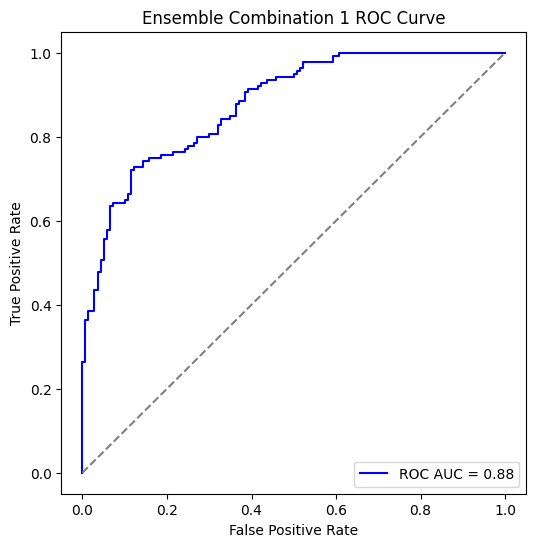


Ensemble Combination 2 Performance:
 Accuracy    : 0.7571
 Precision   : 0.7400
 Recall      : 0.7929
 F1 Score    : 0.7655
 Specificity : 0.7214


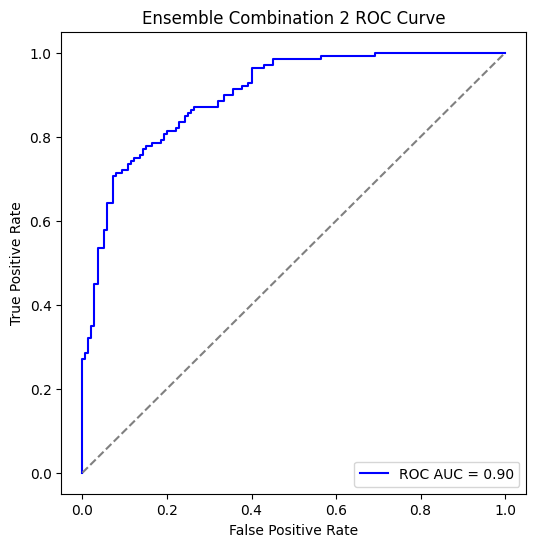


Ensemble Combination 3 Performance:
 Accuracy    : 0.7500
 Precision   : 0.7273
 Recall      : 0.8000
 F1 Score    : 0.7619
 Specificity : 0.7000


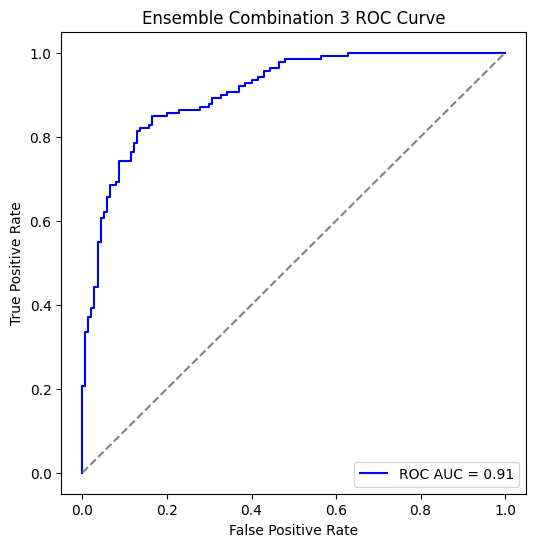

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build RNN-based models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Train classical ML models
# ---------------------------
def train_classical_models(X_train_2d, y_train, X_test_2d):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_2d, y_train)
    y_pred_rf = rf.predict(X_test_2d)
    probs_rf = rf.predict_proba(X_test_2d)[:, 1]

    svm = SVC(probability=True, random_state=42)
    svm.fit(X_train_2d, y_train)
    y_pred_svm = svm.predict(X_test_2d)
    probs_svm = svm.predict_proba(X_test_2d)[:, 1]

    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_2d, y_train)
    y_pred_lr = lr.predict(X_test_2d)
    probs_lr = lr.predict_proba(X_test_2d)[:, 1]

    knn = KNeighborsClassifier()
    knn.fit(X_train_2d, y_train)
    y_pred_knn = knn.predict(X_test_2d)
    probs_knn = knn.predict_proba(X_test_2d)[:, 1]

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train_2d, y_train)
    y_pred_dt = dt.predict(X_test_2d)
    probs_dt = dt.predict_proba(X_test_2d)[:, 1]

    return (y_pred_rf, probs_rf, y_pred_svm, probs_svm,
            y_pred_lr, probs_lr, y_pred_knn, probs_knn,
            y_pred_dt, probs_dt)

# ---------------------------
# Metrics and ROC plot helper
# ---------------------------
def print_metrics_and_plot_roc(y_test, y_pred, probs, title):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp)

    print(f"\n{title} Performance:")
    print(f" Accuracy    : {acc:.4f}")
    print(f" Precision   : {prec:.4f}")
    print(f" Recall      : {rec:.4f}")
    print(f" F1 Score    : {f1:.4f}")
    print(f" Specificity : {spec:.4f}")

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title + " ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# ---------------------------
# Main script
# ---------------------------
if __name__ == "__main__":
    X, y = load_dataset()
    X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

    # Reshape for RNN input: (samples, timesteps=1, features)
    X_selected_3d = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected_3d, y, test_size=0.2, stratify=y, random_state=42
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train RNN
    model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[1]))
    model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_rnn = model_rnn.predict(X_test).ravel()
    y_pred_rnn = (probs_rnn > 0.5).astype(int)

    # Train LSTM
    model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[1]))
    model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_lstm = model_lstm.predict(X_test).ravel()
    y_pred_lstm = (probs_lstm > 0.5).astype(int)

    # Train GRU
    model_gru = build_gru_model(input_shape=(1, X_selected.shape[1]))
    model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    probs_gru = model_gru.predict(X_test).ravel()
    y_pred_gru = (probs_gru > 0.5).astype(int)

    # For classical ML, reshape to 2D
    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[2])
    X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # Train classical ML models & get predictions
    (y_pred_rf, probs_rf, y_pred_svm, probs_svm,
     y_pred_lr, probs_lr, y_pred_knn, probs_knn,
     y_pred_dt, probs_dt) = train_classical_models(X_train_2d, y_train, X_test_2d)

    print("\nSelected features:", selected_features.tolist())

    # ---------------------------
    # Ensemble combinations (hard voting)
    # ---------------------------

    # Combination 1: RNN, LSTM, GRU, RF, SVM, LR, KNN
    preds_combo1 = np.vstack([
        y_pred_rnn, y_pred_lstm, y_pred_gru,
        y_pred_rf, y_pred_svm, y_pred_lr, y_pred_knn
    ]).T
    probs_combo1 = (probs_rnn + probs_lstm + probs_gru + probs_rf + probs_svm + probs_lr + probs_knn) / 7
    ensemble_pred_1 = (np.sum(preds_combo1, axis=1) >= 4).astype(int)
    print_metrics_and_plot_roc(y_test, ensemble_pred_1, probs_combo1, "Ensemble Combination 1")

    # Combination 2: RNN, LSTM, GRU, RF, SVM, LR, DT
    preds_combo2 = np.vstack([
        y_pred_rnn, y_pred_lstm, y_pred_gru,
        y_pred_rf, y_pred_svm, y_pred_lr, y_pred_dt
    ]).T
    probs_combo2 = (probs_rnn + probs_lstm + probs_gru + probs_rf + probs_svm + probs_lr + probs_dt) / 7
    ensemble_pred_2 = (np.sum(preds_combo2, axis=1) >= 4).astype(int)
    print_metrics_and_plot_roc(y_test, ensemble_pred_2, probs_combo2, "Ensemble Combination 2")

    # Combination 3: RNN, LSTM, GRU, RF, SVM, KNN, DT
    preds_combo3 = np.vstack([
        y_pred_rnn, y_pred_lstm, y_pred_gru,
        y_pred_rf, y_pred_svm, y_pred_knn, y_pred_dt
    ]).T
    probs_combo3 = (probs_rnn + probs_lstm + probs_gru + probs_rf + probs_svm + probs_knn + probs_dt) / 7
    ensemble_pred_3 = (np.sum(preds_combo3, axis=1) >= 4).astype(int)
    print_metrics_and_plot_roc(y_test, ensemble_pred_3, probs_combo3, "Ensemble Combination 3")


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Combo 1 (RNN, LSTM, GRU) Majority Voting Ensemble Performance:
 Accuracy    : 0.7143
 Precision   : 0.6923
 Recall      : 0.7714
 F1 Score    : 0.7297
 Specificity : 0.6571
 ROC AUC     : 0.8204


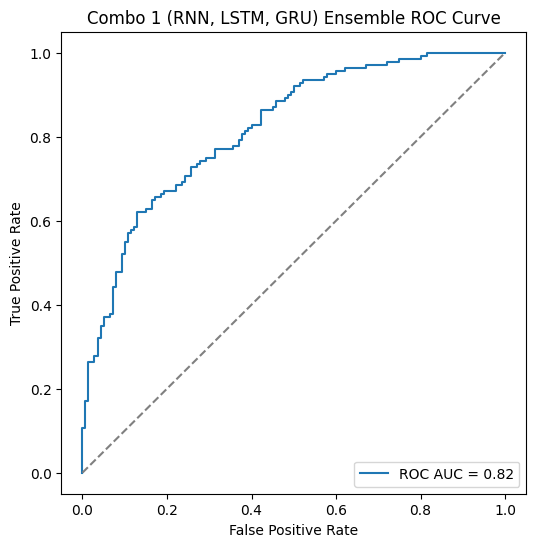


Combo 2 (RNN, LSTM, RNN) Majority Voting Ensemble Performance:
 Accuracy    : 0.7179
 Precision   : 0.7133
 Recall      : 0.7286
 F1 Score    : 0.7208
 Specificity : 0.7071
 ROC AUC     : 0.8231


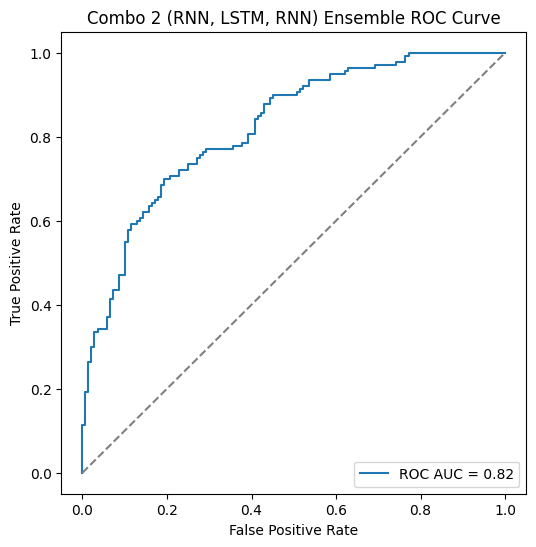


Combo 3 (LSTM, GRU, LSTM) Majority Voting Ensemble Performance:
 Accuracy    : 0.7179
 Precision   : 0.7047
 Recall      : 0.7500
 F1 Score    : 0.7266
 Specificity : 0.6857
 ROC AUC     : 0.8152


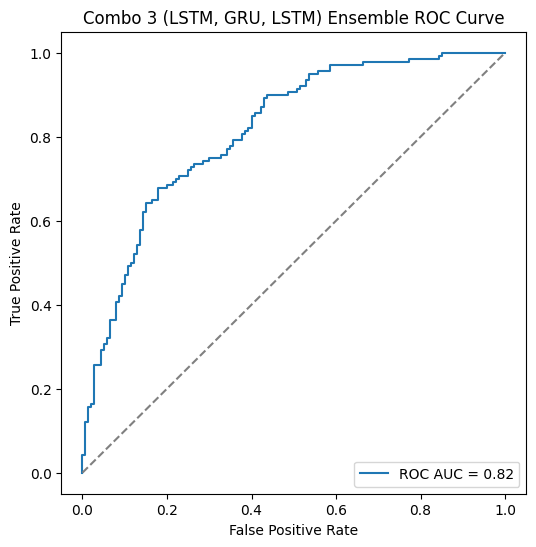


Combo 4 (RNN, GRU, GRU) Majority Voting Ensemble Performance:
 Accuracy    : 0.7071
 Precision   : 0.6835
 Recall      : 0.7714
 F1 Score    : 0.7248
 Specificity : 0.6429
 ROC AUC     : 0.8160


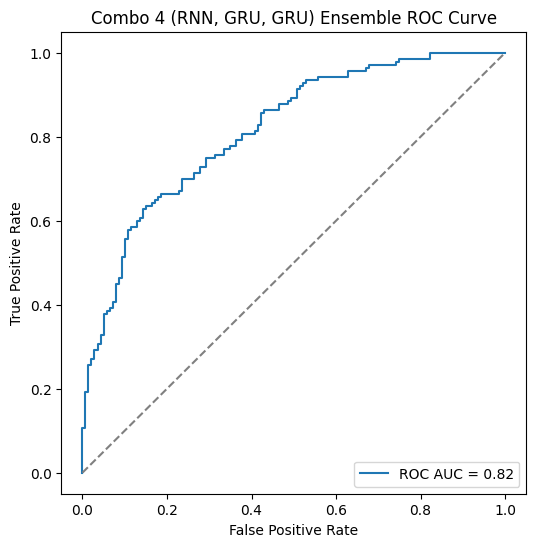


Combo 5 (GRU, LSTM, RNN) Majority Voting Ensemble Performance:
 Accuracy    : 0.7143
 Precision   : 0.6923
 Recall      : 0.7714
 F1 Score    : 0.7297
 Specificity : 0.6571
 ROC AUC     : 0.8204


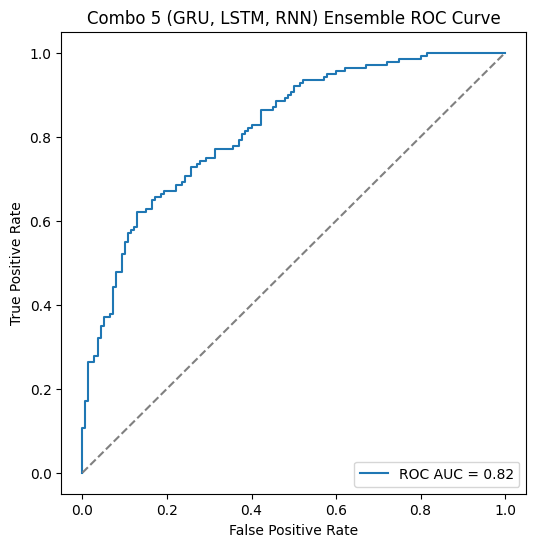


Model Predictions and Ensemble Votes per Sample for Each Combination:

--- Combo 1 (RNN, LSTM, GRU) ---
[('Sample 1', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 2', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 3', {'Ensemble Vote': 0, 'GRU': 0, 'LSTM': 0, 'RNN': 0}),
 ('Sample 4', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 5', {'Ensemble Vote': 0, 'GRU': 0, 'LSTM': 0, 'RNN': 0}),
 ('Sample 6', {'Ensemble Vote': 0, 'GRU': 0, 'LSTM': 0, 'RNN': 0}),
 ('Sample 7', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 8', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 9', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 10', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 11', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 1}),
 ('Sample 12', {'Ensemble Vote': 0, 'GRU': 0, 'LSTM': 0, 'RNN': 0}),
 ('Sample 13', {'Ensemble Vote': 1, 'GRU': 1, 'LSTM': 1, 'RNN': 0}),
 ('Samp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pprint
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Main Script
# ---------------------------
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

# Reshape for RNN input: (samples, timesteps=1, features)
X_selected = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models once
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[2]))
model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[2]))
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

model_gru = build_gru_model(input_shape=(1, X_selected.shape[2]))
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Helper to evaluate and print metrics + ROC
def evaluate_ensemble(name, y_test, all_preds, all_probs):
    ensemble_pred = (np.sum(all_preds, axis=1) >= 2).astype(int)  # majority voting
    acc = accuracy_score(y_test, ensemble_pred)
    prec = precision_score(y_test, ensemble_pred)
    rec = recall_score(y_test, ensemble_pred)
    f1 = f1_score(y_test, ensemble_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
    spec = tn / (tn + fp)
    roc_auc = auc(*roc_curve(y_test, all_probs)[0:2])

    print(f"\n{name} Majority Voting Ensemble Performance:")
    print(f" Accuracy    : {acc:.4f}")
    print(f" Precision   : {prec:.4f}")
    print(f" Recall      : {rec:.4f}")
    print(f" F1 Score    : {f1:.4f}")
    print(f" Specificity : {spec:.4f}")
    print(f" ROC AUC     : {roc_auc:.4f}")

    plt.figure(figsize=(6,6))
    fpr, tpr, _ = roc_curve(y_test, all_probs)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} Ensemble ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return ensemble_pred

# Define combinations of 3 models with their predictions and probabilities
combinations = {
    'Combo 1 (RNN, LSTM, GRU)': {
        'preds': np.vstack([y_pred_rnn, y_pred_lstm, y_pred_gru]).T,
        'probs': (probs_rnn + probs_lstm + probs_gru) / 3,
        'models': ['RNN', 'LSTM', 'GRU']
    },
    'Combo 2 (RNN, LSTM, RNN)': {  # Example: RNN twice (just to illustrate different combos)
        'preds': np.vstack([y_pred_rnn, y_pred_lstm, y_pred_rnn]).T,
        'probs': (probs_rnn + probs_lstm + probs_rnn) / 3,
        'models': ['RNN', 'LSTM', 'RNN']
    },
    'Combo 3 (LSTM, GRU, LSTM)': {
        'preds': np.vstack([y_pred_lstm, y_pred_gru, y_pred_lstm]).T,
        'probs': (probs_lstm + probs_gru + probs_lstm) / 3,
        'models': ['LSTM', 'GRU', 'LSTM']
    },
    'Combo 4 (RNN, GRU, GRU)': {
        'preds': np.vstack([y_pred_rnn, y_pred_gru, y_pred_gru]).T,
        'probs': (probs_rnn + probs_gru + probs_gru) / 3,
        'models': ['RNN', 'GRU', 'GRU']
    },
    'Combo 5 (GRU, LSTM, RNN)': {
        'preds': np.vstack([y_pred_gru, y_pred_lstm, y_pred_rnn]).T,
        'probs': (probs_gru + probs_lstm + probs_rnn) / 3,
        'models': ['GRU', 'LSTM', 'RNN']
    }
}

# Run all combos, evaluate and store ensemble predictions for pretty print
ensemble_results = {}

for combo_name, combo_data in combinations.items():
    ensemble_pred = evaluate_ensemble(combo_name, y_test, combo_data['preds'], combo_data['probs'])
    ensemble_results[combo_name] = {
        'preds': combo_data['preds'],
        'ensemble_pred': ensemble_pred,
        'models': combo_data['models']
    }

# Pretty print per sample predictions for each combo
print("\nModel Predictions and Ensemble Votes per Sample for Each Combination:")
for combo_name, data in ensemble_results.items():
    print(f"\n--- {combo_name} ---")
    results = []
    model_names = data['models']
    for i, preds in enumerate(data['preds']):
        sample_result = {model_names[j]: int(preds[j]) for j in range(len(model_names))}
        sample_result['Ensemble Vote'] = int(data['ensemble_pred'][i])
        results.append((f"Sample {i+1}", sample_result))
    pprint.pprint(results)


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training LSTM...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training GRU...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training ML models...
 Training SVM...
 Training Random Forest...
 Training Logistic Regression...
 Training Decision Tree...
 Training KNN...

Ensemble with 3 models: ['RNN', 'LSTM', 'GRU']
 Accuracy    : 0.6857
 Precision   : 0.6667
 Recall      : 0.7429
 F1 Score    : 0.7027
 Specificity : 0.6286
 ROC AUC     : 0.7906


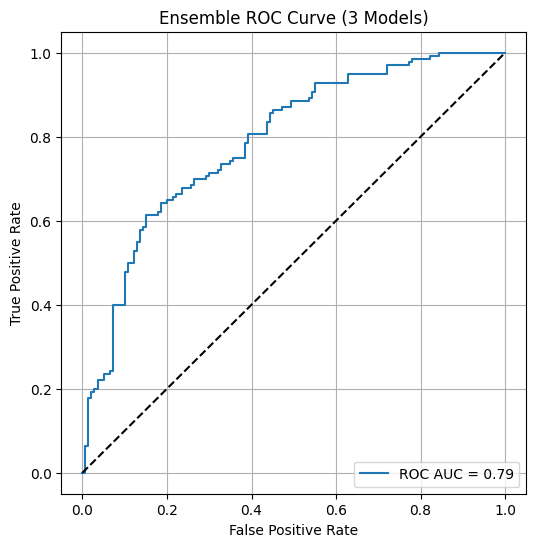


Ensemble with 5 models: ['RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest']
 Accuracy    : 0.7143
 Precision   : 0.6875
 Recall      : 0.7857
 F1 Score    : 0.7333
 Specificity : 0.6429
 ROC AUC     : 0.8687


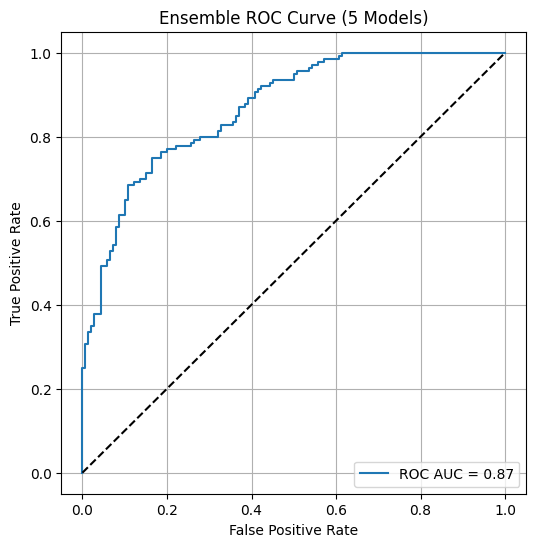


Ensemble with 7 models: ['RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Logistic Regression', 'Decision Tree']
 Accuracy    : 0.7286
 Precision   : 0.7051
 Recall      : 0.7857
 F1 Score    : 0.7432
 Specificity : 0.6714
 ROC AUC     : 0.8930


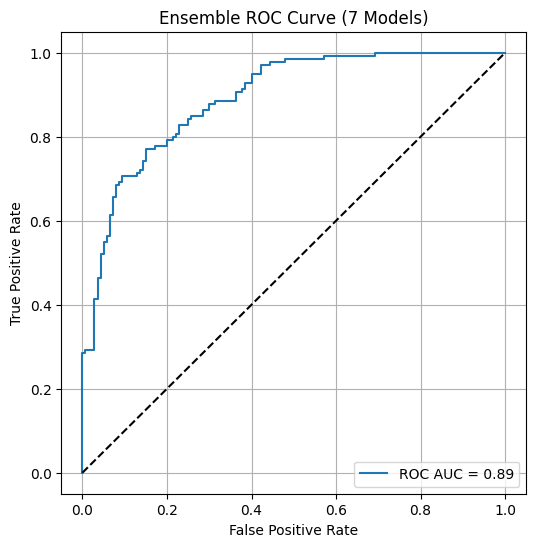

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# ---------------------------
# Feature Selection
# ---------------------------
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# ---------------------------
# Build Models
# ---------------------------
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Main Script
# ---------------------------

# Load and select features
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

# Reshape for DL models: (samples, timesteps=1, features)
X_selected_dl = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

# Split datasets for DL and ML (ML does not require 3D input)
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X_selected_dl, y, test_size=0.2, stratify=y, random_state=42)
X_train_ml, X_test_ml, _, _ = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train DL models
print("Training RNN...")
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[1]))
model_rnn.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test_dl).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

print("Training LSTM...")
model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[1]))
model_lstm.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test_dl).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

print("Training GRU...")
model_gru = build_gru_model(input_shape=(1, X_selected.shape[1]))
model_gru.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test_dl).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Train ML models
ml_models = {
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

ml_preds = {}
ml_probs = {}

print("Training ML models...")
for name, model in ml_models.items():
    print(f" Training {name}...")
    model.fit(X_train_ml, y_train)
    ml_preds[name] = model.predict(X_test_ml)
    ml_probs[name] = model.predict_proba(X_test_ml)[:, 1]

# Collect all predictions and probabilities
all_preds = {
    'RNN': y_pred_rnn,
    'LSTM': y_pred_lstm,
    'GRU': y_pred_gru,
    **ml_preds
}

all_probs = {
    'RNN': probs_rnn,
    'LSTM': probs_lstm,
    'GRU': probs_gru,
    **ml_probs
}

# Ensemble evaluation function
def evaluate_ensemble(y_test, model_names):
    preds_stack = np.vstack([all_preds[m] for m in model_names]).T
    probs_stack = np.vstack([all_probs[m] for m in model_names]).T

    # Majority vote threshold (more than half)
    threshold = len(model_names) // 2 + 1
    ensemble_pred = (np.sum(preds_stack, axis=1) >= threshold).astype(int)
    ensemble_prob = np.mean(probs_stack, axis=1)

    acc = accuracy_score(y_test, ensemble_pred)
    prec = precision_score(y_test, ensemble_pred)
    rec = recall_score(y_test, ensemble_pred)
    f1 = f1_score(y_test, ensemble_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
    spec = tn / (tn + fp)
    fpr, tpr, _ = roc_curve(y_test, ensemble_prob)
    roc_auc = auc(fpr, tpr)

    print(f"\nEnsemble with {len(model_names)} models: {model_names}")
    print(f" Accuracy    : {acc:.4f}")
    print(f" Precision   : {prec:.4f}")
    print(f" Recall      : {rec:.4f}")
    print(f" F1 Score    : {f1:.4f}")
    print(f" Specificity : {spec:.4f}")
    print(f" ROC AUC     : {roc_auc:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Ensemble ROC Curve ({len(model_names)} Models)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Define model combinations
comb_3 = ['RNN', 'LSTM', 'GRU']  # 3 DL models
comb_5 = ['RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest']  # add 2 ML models
comb_7 = ['RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Logistic Regression', 'Decision Tree']  # 7 models

# Evaluate ensembles
evaluate_ensemble(y_test, comb_3)
evaluate_ensemble(y_test, comb_5)
evaluate_ensemble(y_test, comb_7)


c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training LSTM...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training GRU...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training ML models...
 Training SVM...
 Training Random Forest...
 Training Logistic Regression...
 Training Decision Tree...
 Training KNN...

Evaluating first 4 mixed (DL+ML) combinations of size 3:

Ensemble (3 models): ('RNN', 'LSTM', 'SVM')
 Accuracy    : 0.7143
 Precision   : 0.6948
 Recall      : 0.7643
 F1 Score    : 0.7279
 Specificity : 0.6643
 ROC AUC     : 0.8159


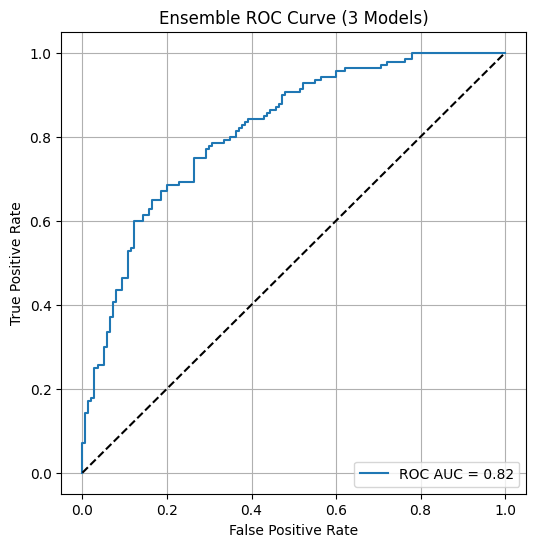


Ensemble (3 models): ('RNN', 'LSTM', 'Random Forest')
 Accuracy    : 0.7429
 Precision   : 0.7329
 Recall      : 0.7643
 F1 Score    : 0.7483
 Specificity : 0.7214
 ROC AUC     : 0.8993


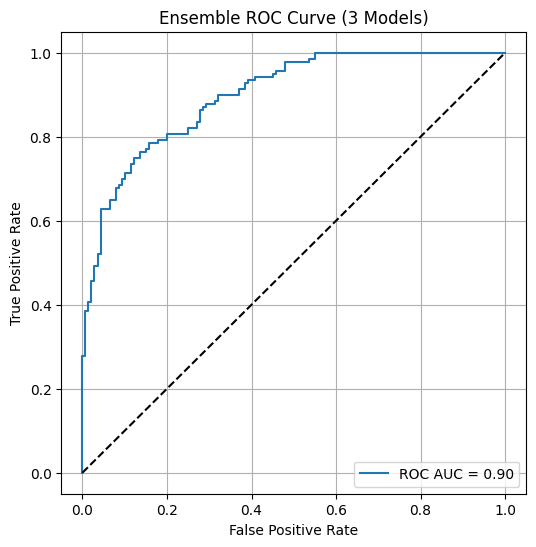


Ensemble (3 models): ('RNN', 'LSTM', 'Logistic Regression')
 Accuracy    : 0.7036
 Precision   : 0.6993
 Recall      : 0.7143
 F1 Score    : 0.7067
 Specificity : 0.6929
 ROC AUC     : 0.7853


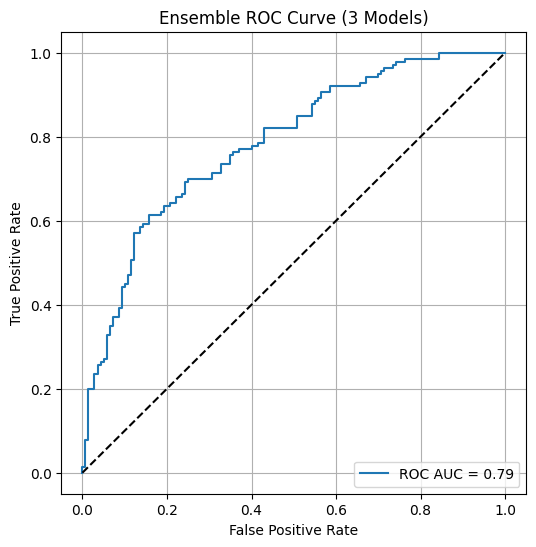


Ensemble (3 models): ('RNN', 'LSTM', 'Decision Tree')
 Accuracy    : 0.7250
 Precision   : 0.7114
 Recall      : 0.7571
 F1 Score    : 0.7336
 Specificity : 0.6929
 ROC AUC     : 0.8791


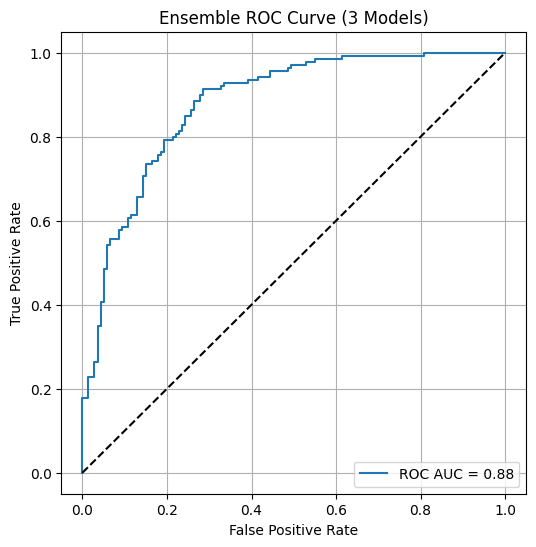


Evaluating first 4 mixed (DL+ML) combinations of size 5:

Ensemble (5 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest')
 Accuracy    : 0.7143
 Precision   : 0.6948
 Recall      : 0.7643
 F1 Score    : 0.7279
 Specificity : 0.6643
 ROC AUC     : 0.8716


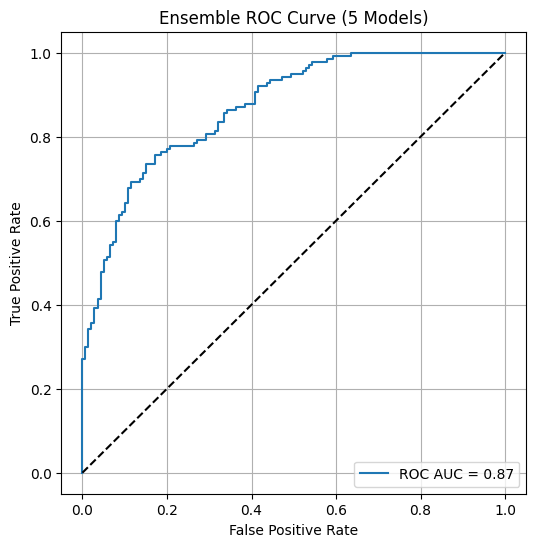


Ensemble (5 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Logistic Regression')
 Accuracy    : 0.7071
 Precision   : 0.6908
 Recall      : 0.7500
 F1 Score    : 0.7192
 Specificity : 0.6643
 ROC AUC     : 0.8042


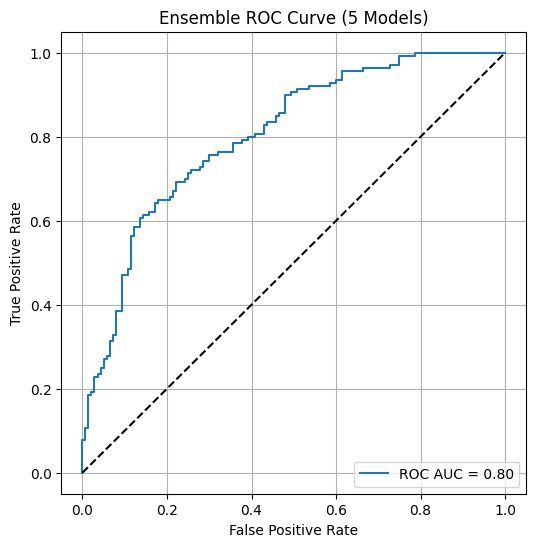


Ensemble (5 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Decision Tree')
 Accuracy    : 0.7107
 Precision   : 0.6903
 Recall      : 0.7643
 F1 Score    : 0.7254
 Specificity : 0.6571
 ROC AUC     : 0.8707


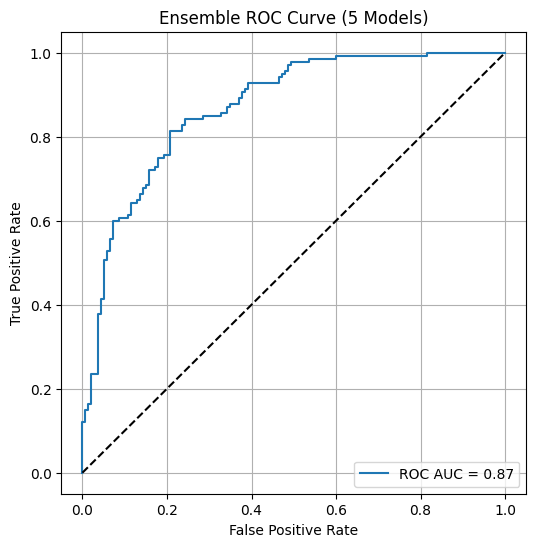


Ensemble (5 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'KNN')
 Accuracy    : 0.7071
 Precision   : 0.6883
 Recall      : 0.7571
 F1 Score    : 0.7211
 Specificity : 0.6571
 ROC AUC     : 0.8326


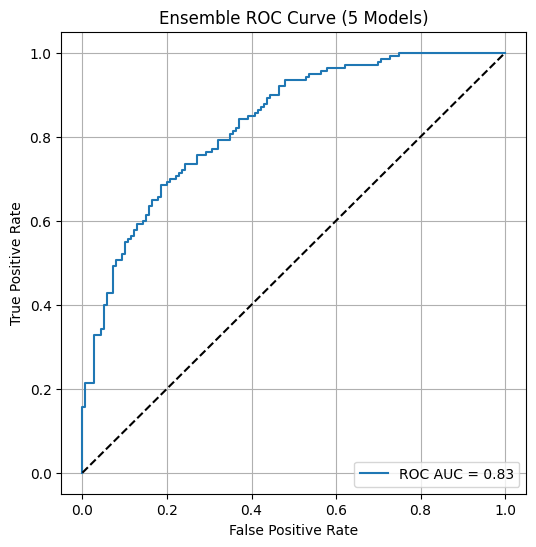


Evaluating first 4 mixed (DL+ML) combinations of size 7:

Ensemble (7 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Logistic Regression', 'Decision Tree')
 Accuracy    : 0.7357
 Precision   : 0.7200
 Recall      : 0.7714
 F1 Score    : 0.7448
 Specificity : 0.7000
 ROC AUC     : 0.8946


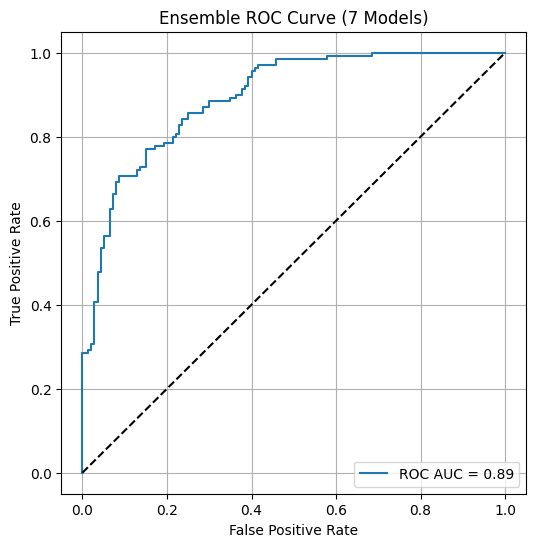


Ensemble (7 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Logistic Regression', 'KNN')
 Accuracy    : 0.7214
 Precision   : 0.7013
 Recall      : 0.7714
 F1 Score    : 0.7347
 Specificity : 0.6714
 ROC AUC     : 0.8701


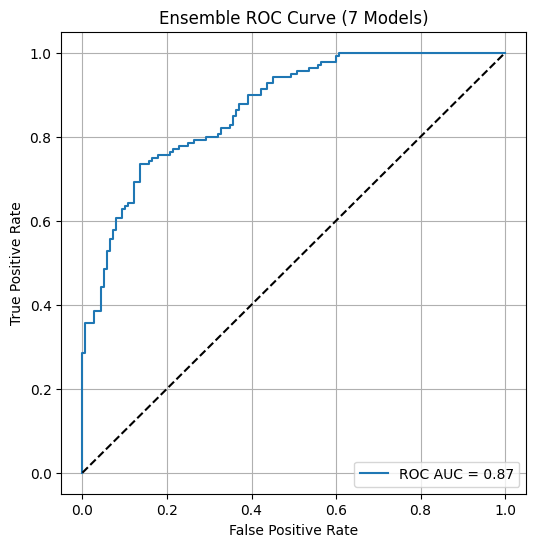


Ensemble (7 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Decision Tree', 'KNN')
 Accuracy    : 0.7429
 Precision   : 0.7125
 Recall      : 0.8143
 F1 Score    : 0.7600
 Specificity : 0.6714
 ROC AUC     : 0.9039


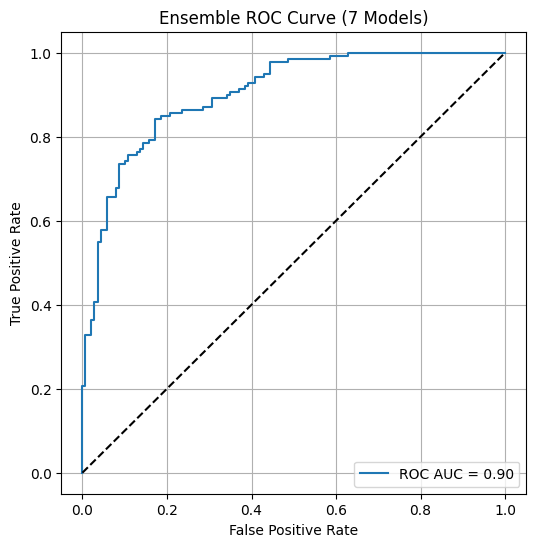


Ensemble (7 models): ('RNN', 'LSTM', 'GRU', 'SVM', 'Logistic Regression', 'Decision Tree', 'KNN')
 Accuracy    : 0.7179
 Precision   : 0.6968
 Recall      : 0.7714
 F1 Score    : 0.7322
 Specificity : 0.6643
 ROC AUC     : 0.8719


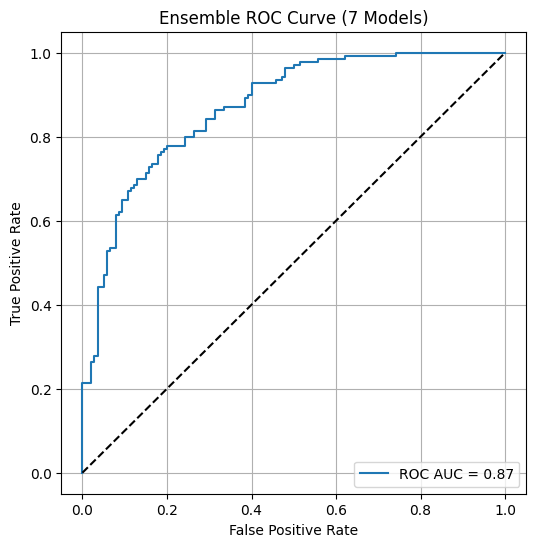

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# --- Load Dataset ---
def load_dataset():
    data = pd.read_csv('final-dataset.csv')
    X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
    y = data['Label']
    return X, y

# --- Feature Selection ---
def select_features(X, y, method='f_classif', k=20):
    feature_names = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_scaled, y)
    selected_feature_names = feature_names[selector.get_support()]
    X_selected = selector.transform(X_scaled)
    return X_selected, selected_feature_names

# --- Build DL Models ---
def build_rnn_model(input_shape, units=128):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, units=128):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, units=128):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Main ---
X, y = load_dataset()
X_selected, selected_features = select_features(X, y, method='f_classif', k=20)

# Prepare DL input shape
X_selected_dl = X_selected.reshape((X_selected.shape[0], 1, X_selected.shape[1]))

X_train_dl, X_test_dl, y_train, y_test = train_test_split(X_selected_dl, y, test_size=0.2, stratify=y, random_state=42)
X_train_ml, X_test_ml, _, _ = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train DL models
print("Training RNN...")
model_rnn = build_rnn_model(input_shape=(1, X_selected.shape[1]))
model_rnn.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_rnn = model_rnn.predict(X_test_dl).ravel()
y_pred_rnn = (probs_rnn > 0.5).astype(int)

print("Training LSTM...")
model_lstm = build_lstm_model(input_shape=(1, X_selected.shape[1]))
model_lstm.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_lstm = model_lstm.predict(X_test_dl).ravel()
y_pred_lstm = (probs_lstm > 0.5).astype(int)

print("Training GRU...")
model_gru = build_gru_model(input_shape=(1, X_selected.shape[1]))
model_gru.fit(X_train_dl, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
probs_gru = model_gru.predict(X_test_dl).ravel()
y_pred_gru = (probs_gru > 0.5).astype(int)

# Train ML models
ml_models = {
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

ml_preds = {}
ml_probs = {}

print("Training ML models...")
for name, model in ml_models.items():
    print(f" Training {name}...")
    model.fit(X_train_ml, y_train)
    ml_preds[name] = model.predict(X_test_ml)
    ml_probs[name] = model.predict_proba(X_test_ml)[:, 1]

# Collect all predictions and probabilities
all_preds = {
    'RNN': y_pred_rnn,
    'LSTM': y_pred_lstm,
    'GRU': y_pred_gru,
    **ml_preds
}

all_probs = {
    'RNN': probs_rnn,
    'LSTM': probs_lstm,
    'GRU': probs_gru,
    **ml_probs
}

dl_models = {'RNN', 'LSTM', 'GRU'}
ml_models_set = set(ml_models.keys())

# Evaluate Ensemble
def evaluate_ensemble(y_test, model_names):
    preds_stack = np.vstack([all_preds[m] for m in model_names]).T
    probs_stack = np.vstack([all_probs[m] for m in model_names]).T

    threshold = len(model_names) // 2 + 1
    ensemble_pred = (np.sum(preds_stack, axis=1) >= threshold).astype(int)
    ensemble_prob = np.mean(probs_stack, axis=1)

    acc = accuracy_score(y_test, ensemble_pred)
    prec = precision_score(y_test, ensemble_pred)
    rec = recall_score(y_test, ensemble_pred)
    f1 = f1_score(y_test, ensemble_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()
    spec = tn / (tn + fp)
    fpr, tpr, _ = roc_curve(y_test, ensemble_prob)
    roc_auc = auc(fpr, tpr)

    print(f"\nEnsemble ({len(model_names)} models): {model_names}")
    print(f" Accuracy    : {acc:.4f}")
    print(f" Precision   : {prec:.4f}")
    print(f" Recall      : {rec:.4f}")
    print(f" F1 Score    : {f1:.4f}")
    print(f" Specificity : {spec:.4f}")
    print(f" ROC AUC     : {roc_auc:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Ensemble ROC Curve ({len(model_names)} Models)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# All model names
model_names_list = list(all_preds.keys())  # ['RNN', 'LSTM', 'GRU', 'SVM', 'Random Forest', 'Logistic Regression', 'Decision Tree', 'KNN']

# Function to check if combo mixes DL and ML models
def is_mixed_combo(combo):
    has_dl = any(m in dl_models for m in combo)
    has_ml = any(m in ml_models_set for m in combo)
    return has_dl and has_ml

# Function to evaluate first 4 mixed combos of each size
def evaluate_mixed_combinations(model_names_list, combo_size, num_combos=4):
    combos = [c for c in itertools.combinations(model_names_list, combo_size) if is_mixed_combo(c)]
    combos = combos[:num_combos]
    print(f"\nEvaluating first {num_combos} mixed (DL+ML) combinations of size {combo_size}:")
    for combo in combos:
        evaluate_ensemble(y_test, combo)

# Evaluate mixed combos of size 3, 5, 7
evaluate_mixed_combinations(model_names_list, 3, 4)
evaluate_mixed_combinations(model_names_list, 5, 4)
evaluate_mixed_combinations(model_names_list, 7, 4)
